In [1]:
!pip install torch torchvision tqdm torchinfo numpy pandas matplotlib seaborn Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from IPython.display import display
from PIL import Image

from tqdm.auto import tqdm
from torchinfo import summary

%matplotlib inline
sns.set()

print(f'Torch Verison: {torch.__version__}')
print(f'Torchvision Verison: {torchvision.__version__}')

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Torch Verison: 1.13.0+cu116
Torchvision Verison: 0.14.0+cu116


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [76]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomAffine(degrees=0, scale=(0.5, 1.3)),
    # transforms.RandomAffine(degrees=0, shear=(-5, 5, -5, 5)),
    # transforms.RandomInvert(p=0.3),
    # transforms.RandomApply([
    #     transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2)),
    # ], p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize(0.1307, 0.3081) # mean and std of mnist dataset
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(0.1307, 0.3081)
])

In [77]:
train_dataset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=train_transform)
valid_dataset = torchvision.datasets.MNIST(root='./dataset', train=False, transform=test_transform)

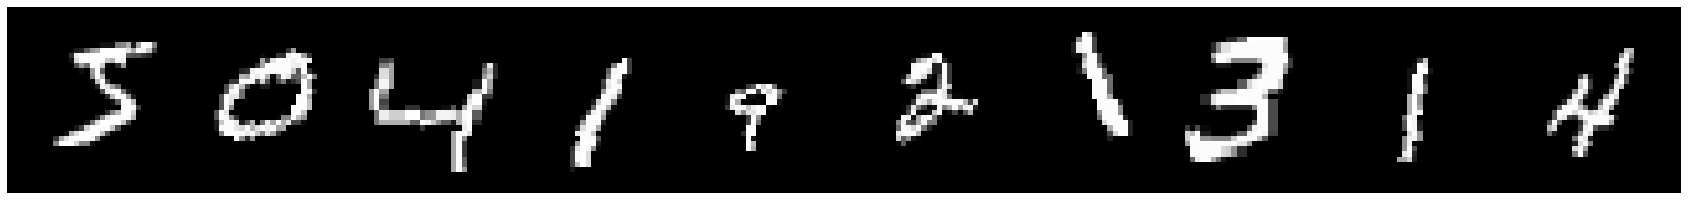

['5 - five', '0 - zero', '4 - four', '1 - one', '9 - nine', '2 - two', '1 - one', '3 - three', '1 - one', '4 - four']


In [78]:
images, labels = zip(*[train_dataset[i] for i in range(10)])
images = torch.stack(images)

grid = torchvision.utils.make_grid(images, nrow=10, padding=4)

fig, ax = plt.subplots(figsize=(30, 30))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()
print([train_dataset.classes[label] for label in labels])

In [79]:
EPOCHS = 32
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
CHANNELS = 1
LATENT_DIM = 128
WIDTH = 28
HEIGHT = 28
WEIGHT_DECAY = 1e-6

In [80]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

tensor(0.) tensor(1.)


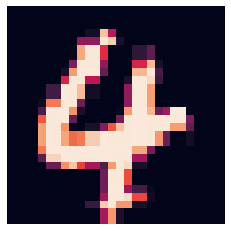

In [81]:
train_iter = iter(train_loader)
images, labels = next(train_iter)

print(torch.min(images), torch.max(images))

plt.axis('off')
plt.imshow(transforms.ToPILImage()(images[0]))

In [82]:
class Encoder(nn.Module):
    def __init__(self, channels, latent_dim):
        super(Encoder, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=3, stride=2, padding=3, dilation=1, bias=True, padding_mode='zeros'), # N, 16, 16, 16
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1), # N, 16, 8, 8
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), # N, 32, 4, 4
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=latent_dim, kernel_size=4), # N, latent_dim, 1, 1
        )


    def forward(self, x):
        x = self.net(x)

        '''
            It is common practice to not use an activation function in the last layer of the encoder in an autoencoder. 
            This is because the last layer of the encoder should output a representation that captures the essential features of the input data, 
            and an activation function could distort this representation by introducing non-linearity.
        '''

        return x

summary(model=Encoder(channels=CHANNELS, latent_dim=LATENT_DIM), input_size=[BATCH_SIZE, CHANNELS, WIDTH, HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [64, 128, 1, 1]           --
├─Sequential: 1-1                        [64, 128, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 16, 16, 16]          160
│    └─LeakyReLU: 2-2                    [64, 16, 16, 16]          --
│    └─Conv2d: 2-3                       [64, 16, 8, 8]            2,320
│    └─LeakyReLU: 2-4                    [64, 16, 8, 8]            --
│    └─Conv2d: 2-5                       [64, 32, 4, 4]            4,640
│    └─LeakyReLU: 2-6                    [64, 32, 4, 4]            --
│    └─Conv2d: 2-7                       [64, 128, 1, 1]           65,664
Total params: 72,784
Trainable params: 72,784
Non-trainable params: 0
Total mult-adds (M): 21.08
Input size (MB): 0.20
Forward/backward pass size (MB): 2.95
Params size (MB): 0.29
Estimated Total Size (MB): 3.44

In [83]:
class Decoder(nn.Module):
    def __init__(self, channels, latent_dim):
        super(Decoder, self).__init__()

        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=32, kernel_size=(4, 4), stride=1, padding=0, dilation=1, bias=True, padding_mode='zeros'), # N, 32, 4, 4
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 16, 7, 7 -> with output_padding=1 we get N, 16, 8, 8
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 16, 16, 16
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=16, out_channels=channels, kernel_size=3, stride=2, padding=3, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid() # as we have normalized the dataset, so our range is from [0, 1], so we want sigmoid, if it had been [-1, 1], i.e, mean=0.5 and std=0.5 we would have used tanh
        )

    def forward(self, x):
        x = self.net(x)
        return x

# if we use MaxPool2d, we have to use MaxUnpool2d
# if dataset is in range of [-1, 1], consider using leaky-relu 

summary(model=Decoder(channels=CHANNELS, latent_dim=LATENT_DIM), input_size=[BATCH_SIZE, LATENT_DIM, 1, 1])

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [64, 1, 28, 28]           --
├─Sequential: 1-1                        [64, 1, 28, 28]           --
│    └─ConvTranspose2d: 2-1              [64, 32, 4, 4]            65,568
│    └─LeakyReLU: 2-2                    [64, 32, 4, 4]            --
│    └─ConvTranspose2d: 2-3              [64, 16, 8, 8]            4,624
│    └─LeakyReLU: 2-4                    [64, 16, 8, 8]            --
│    └─ConvTranspose2d: 2-5              [64, 16, 16, 16]          2,320
│    └─LeakyReLU: 2-6                    [64, 16, 16, 16]          --
│    └─ConvTranspose2d: 2-7              [64, 1, 28, 28]           145
│    └─Sigmoid: 2-8                      [64, 1, 28, 28]           --
Total params: 72,657
Trainable params: 72,657
Non-trainable params: 0
Total mult-adds (M): 131.37
Input size (MB): 0.03
Forward/backward pass size (MB): 3.28
Params size (MB): 0.29
Estimated Total Size (MB): 3.61

In [84]:
# AutoEncoders are also a type of generative model
class AutoEncoder(nn.Module):
    def __init__(self, channels, latent_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(channels, latent_dim).to(device)
        self.decoder = Decoder(channels, latent_dim).to(device)
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat

summary(model=AutoEncoder(channels=CHANNELS, latent_dim=LATENT_DIM), input_size=[BATCH_SIZE, CHANNELS, WIDTH, HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [64, 1, 28, 28]           --
├─Encoder: 1-1                           [64, 128, 1, 1]           --
│    └─Sequential: 2-1                   [64, 128, 1, 1]           --
│    │    └─Conv2d: 3-1                  [64, 16, 16, 16]          160
│    │    └─LeakyReLU: 3-2               [64, 16, 16, 16]          --
│    │    └─Conv2d: 3-3                  [64, 16, 8, 8]            2,320
│    │    └─LeakyReLU: 3-4               [64, 16, 8, 8]            --
│    │    └─Conv2d: 3-5                  [64, 32, 4, 4]            4,640
│    │    └─LeakyReLU: 3-6               [64, 32, 4, 4]            --
│    │    └─Conv2d: 3-7                  [64, 128, 1, 1]           65,664
├─Decoder: 1-2                           [64, 1, 28, 28]           --
│    └─Sequential: 2-2                   [64, 1, 28, 28]           --
│    │    └─ConvTranspose2d: 3-8         [64, 32, 4, 4]            65,568


In [85]:
autoencoder = AutoEncoder(channels=CHANNELS, latent_dim=LATENT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(params=autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [86]:
for epoch in tqdm(range(EPOCHS)):
    autoencoder.train()

    train_loss = 0.0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        autoencoder.zero_grad()

    scheduler.step()

    autoencoder.eval()

    valid_loss = 0.0
    with torch.inference_mode():
        for images, _ in valid_loader:
            images = images.to(device)

            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            valid_loss += loss.item()

    if not (epoch + 1) % 10 or epoch == EPOCHS - 1:
        print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 39.2270, Valid Loss: 2.4287
Epoch: 2, Train Loss: 15.3329, Valid Loss: 1.5312
Epoch: 3, Train Loss: 12.2210, Valid Loss: 1.2403
Epoch: 4, Train Loss: 10.6214, Valid Loss: 1.0468
Epoch: 5, Train Loss: 9.6591, Valid Loss: 0.9143
Epoch: 6, Train Loss: 8.8992, Valid Loss: 0.8207
Epoch: 7, Train Loss: 8.3141, Valid Loss: 0.7540
Epoch: 8, Train Loss: 7.8016, Valid Loss: 0.6960
Epoch: 9, Train Loss: 7.2034, Valid Loss: 0.6178
Epoch: 10, Train Loss: 7.1106, Valid Loss: 0.6079
Epoch: 11, Train Loss: 7.0664, Valid Loss: 0.6022
Epoch: 12, Train Loss: 6.9678, Valid Loss: 0.5960
Epoch: 13, Train Loss: 6.9074, Valid Loss: 0.5883
Epoch: 14, Train Loss: 6.8768, Valid Loss: 0.5798
Epoch: 15, Train Loss: 6.8057, Valid Loss: 0.5740
Epoch: 16, Train Loss: 6.7257, Valid Loss: 0.5675
Epoch: 17, Train Loss: 6.6678, Valid Loss: 0.5587
Epoch: 18, Train Loss: 6.6543, Valid Loss: 0.5577
Epoch: 19, Train Loss: 6.6421, Valid Loss: 0.5570
Epoch: 20, Train Loss: 6.6164, Valid Loss: 0.5563
Epoch

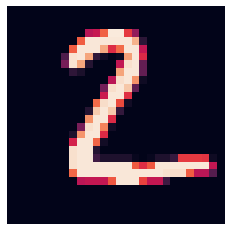

In [87]:
valid_iter = iter(valid_loader)
images, _ = next(valid_iter)

img = images[1]

plt.axis('off')
plt.imshow(transforms.ToPILImage()(img))

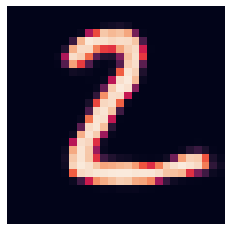

In [88]:
encoder = autoencoder.encoder
decoder = autoencoder.decoder

img = img.unsqueeze(dim=0).to(device) # unsqueeze because we have passed a batch of inputs to trained model

gen_img = decoder(encoder(img)) 
gen_img = gen_img.squeeze()

plt.axis('off')
plt.imshow(transforms.ToPILImage()(gen_img))